In [1]:
import os
os.chdir("/Users/User/P2")
print(os.getcwd())

C:\Users\User\P2


In [2]:
import pandas as pd
import numpy as np 

#load the data
data = pd.read_csv("SW_chl_oc4me-cleaned.csv")
print(data.shape)
print(data.info())

(1640, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1640 non-null   object 
 1   SW_chl_oc4me  1640 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None


In [3]:
# ADF Test = testing if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['SW_chl_oc4me'])

def adfuller_test(SW_chl_oc4me):
    result=adfuller(SW_chl_oc4me)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['SW_chl_oc4me'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -3.6399960171492625
p-value : 0.005040850252110725
#Lags Used : 24
Number of Observations : 1615


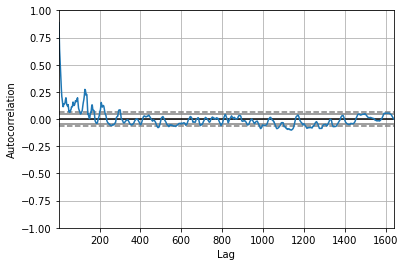

In [4]:
#autocorrelation

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline

autocorrelation_plot(data['SW_chl_oc4me'])
plt.show()

In [5]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#preprocessing (since arima takes univariate series as input)
train.drop('Date',axis=1,inplace=True)
valid.drop('Date',axis=1,inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


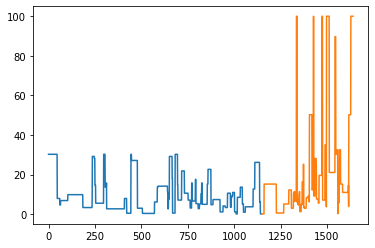

In [6]:
#plotting the data

train['SW_chl_oc4me'].plot()
valid['SW_chl_oc4me'].plot()


In [7]:
#building the model (with optimal p,d,q value)
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit=model.fit(train)

model_fit

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5595.340, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8297.594, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5596.843, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7195.945, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9166.744, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5595.163, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6539.045, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5597.788, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5596.525, Time=0.46 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=6229.349, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5600.104, Time=1.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5597.333, Time=3.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5610.948, Time=0.34 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.600 seconds


In [8]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1148
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2792.581
Date:                Mon, 24 Jan 2022   AIC                           5595.163
Time:                        00:10:07   BIC                           5620.392
Sample:                             0   HQIC                          5604.687
                               - 1148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5495      0.317      1.733      0.083      -0.072       1.171
ar.L1          0.9434      0.020     46.413      0.000       0.904       0.983
ma.L1          0.0414      0.080      0.520      0.603      -0.115       0.198
ma.L2          0.0636      0.039      1.627      0.104      -0.013       0.140
sigma2         7.5773      0.148     51.133      0.000       7.287       7.868
===================================================================================
Ljung-Box (Q):                       45.26   Jarque-Bera (JB):            116850.24
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             1.60
Prob(H) (two-sided):                  0.71   Kurtosis:                        52.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

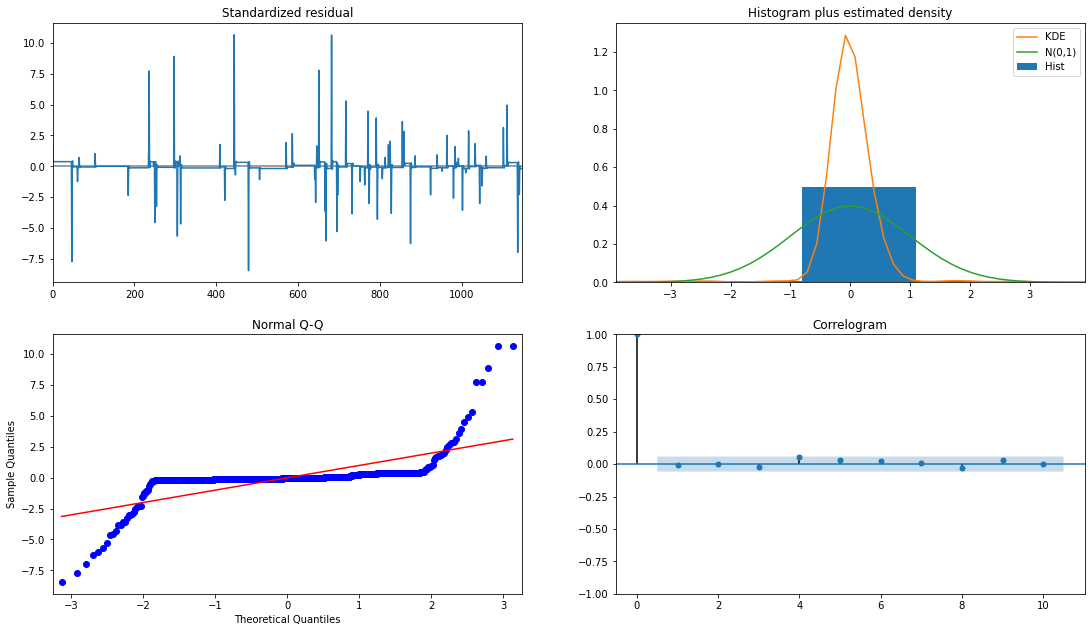

In [9]:
fig = model_fit.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)

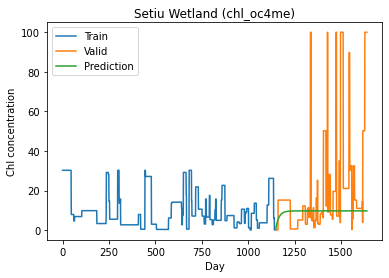

In [10]:
#plot the predictions for validation set

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.xlabel("Day")
plt.ylabel("Chl concentration")
plt.legend(loc="upper left")
plt.title("Setiu Wetland (chl_oc4me)")
plt.show()

In [11]:
#model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score


print('Mean Absolute Error:', metrics.mean_absolute_error(valid,forecast))
print('Mean Squared Error:', metrics.mean_squared_error(valid,forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid,forecast)))
print('R Squared value:',r2_score(valid,forecast))

Mean Absolute Error: 15.02333488722954
Mean Squared Error: 780.8874333232146
Root Mean Squared Error: 27.944363176197353
R Squared value: -0.16888499655152978
